# Disaster Tweets data analysis

In [1]:
import numpy as np
import re
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, ensemble, model_selection, pipeline, compose, preprocessing
from keyword_transformer import KeywordTransformer
from location_transformer import LocationTransformer
from text_stats_transformer import TextStatsTransformer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# import spacy
# spacy.cli.download('en_core_web_sm')


In [2]:
df_train = pd.read_csv('./train_enriched.csv', index_col='id')
df_test = pd.read_csv('./test_enriched.csv', index_col='id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7613 entries, 0 to 7612
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   keyword              7552 non-null   object 
 1   positive_factor      7613 non-null   float64
 2   location             5080 non-null   object 
 3   country              2648 non-null   object 
 4   state                1640 non-null   object 
 5   city                 1518 non-null   object 
 6   missing_location     7613 non-null   int64  
 7   text                 7613 non-null   object 
 8   clean_text           7611 non-null   object 
 9   text_length          7613 non-null   int64  
 10  upper_text_factor    7613 non-null   float64
 11  tags_count           7613 non-null   int64  
 12  punct_factor         7613 non-null   float64
 13  ann_count            7613 non-null   int64  
 14  urls_count           7613 non-null   int64  
 15  tokens_count         7613 non-null   int64 

In [3]:
df_train.sample(n=10)

,keyword,positive_factor,location,country,state,city,missing_location,text,clean_text,text_length,...,punct_factor,ann_count,urls_count,tokens_count,stop_words_factor,clean_tokens_factor,url_domains,url_redirects_count,hashtags_sentiment,target
id,,,,,,,,,,,,,,,,,,,,,
6347,structural%20failure,0.657143,NaN,NaN,NaN,NaN,1,@sirtophamhat @SCynic1 @NafeezAhmed @jeremydun...,course melt steel order cause structural failure,113,...,0.053097,4,0,20,0.450000,0.550000,NaN,0,0.000000,0
6080,sinkhole,0.692308,Newcastle,South Africa,NaN,Newcastle,0,Sinkhole leaking sewage opens in housing estat...,sinkhole leaking sewage open housing estate ir...,67,...,0.014925,0,0,11,0.090909,0.909091,NaN,0,0.000000,1
1214,buildings%20burning,0.685714,"Epic City, BB.",BB,NaN,NaN,0,I Pledge Allegiance To The P.O.P.E. And The Bu...,pledge allegiance pope burning building epic city,69,...,0.159420,0,0,14,0.071429,0.928571,NaN,0,0.000000,0
7290,whirlwind,0.358974,Phila.,NaN,NaN,NaN,0,MY GIRL GOT A GIRLFRIEND CHEVY BLUE LIKE WHIRL...,girl got girlfriend chevy blue like whirlwind,43,...,0.023256,0,0,9,0.000000,1.000000,NaN,0,0.000000,0
5821,rubble,0.357143,Phoenix Az,NaN,NaN,NaN,0,@JasonPope2 @JohnFugelsang again I didn't say ...,say wa referring main building hit rubble,94,...,0.053191,2,0,21,0.380952,0.619048,NaN,0,0.000000,1
89,accident,0.685714,"Wilmington, NC",United States,North Carolina,Wilmington,0,;ACCIDENT PROPERTY DAMAGE; PINER RD/HORNDALE DR,accident property damage piner rdhorndale dr,42,...,0.071429,0,0,6,0.000000,1.000000,NaN,0,0.000000,1
7233,weapons,0.435897,california | oregon | peru |,United States,Ohio,Oregon,0,@DorisMatsui thank you for supporting the Pres...,thank supporting president irandeal take nucle...,118,...,0.033898,1,0,22,0.363636,0.636364,NaN,0,-0.111111,0
5561,rainstorm,0.529412,Thailand Malaysia Indonesia,Thailand,NaN,NaN,0,Nigeria: Rainstorm Destroys 600 Houses in Yobe...,nigeria rainstorm destroys house yobe state da...,99,...,0.111111,0,1,14,0.071429,0.857143,feedburner.com,2,0.000000,1
3801,fire%20truck,0.666667,"Nevada Carson City,Freeman St",United States,Nevada,Carson City,0,rgj: Truck trailer catches fire in Reno http:/...,rgj truck trailer catch fire reno,55,...,0.109091,0,1,8,0.125000,0.750000,rgj.com,1,0.000000,1


In [4]:
df_train.fillna(value={'keyword': '', 'location': '', 'clean_text': ''}, inplace=True)
df_train.sample(n=10)

,keyword,positive_factor,location,country,state,city,missing_location,text,clean_text,text_length,...,punct_factor,ann_count,urls_count,tokens_count,stop_words_factor,clean_tokens_factor,url_domains,url_redirects_count,hashtags_sentiment,target
id,,,,,,,,,,,,,,,,,,,,,
2021,damage,0.463415,"Bhopal, Madhya Pradesh, India.",India,NaN,NaN,0,@MichaelWestBiz standard damage control,standard damage control,36,...,0.027778,1,0,4,0.000000,1.000000,NaN,0,0.000000,1
4321,hijack,0.484848,Houston TX,NaN,NaN,NaN,0,Tension In Bayelsa As Patience Jonathan Plans ...,tension bayelsa patience jonathan plan hijack ...,76,...,0.078947,0,1,13,0.000000,0.923077,madailygist.com,2,0.000000,1
183,ambulance,0.526316,Amsterdam,Netherlands,NaN,Amsterdam,0,http://t.co/7xGLah10zL Twelve feared killed in...,twelve feared killed pakistani air ambulance h...,100,...,0.100000,0,2,11,0.090909,0.727273,batidodeproteina.com owl.li,3,0.000000,1
2994,dust%20storm,0.666667,"El Paso, Texas",United States,Texas,El Paso,0,NASA MODIS image: Dust storm over Morocco and ...,nasa modis image dust storm morocco strait gib...,91,...,0.076923,0,1,14,0.285714,0.642857,nasa.gov,1,1.000000,1
3575,famine,0.666667,"Chatham, IL",United States,Illinois,Chatham,0,Images of Famine ÛÒ Hope In Christ - A blog o...,image famine ûò hope christ blog happens forg...,113,...,0.070796,1,1,20,0.250000,0.700000,lifelettercafe.com,1,1.000000,1
1688,collide,0.088235,"New Orleans, LA",United States,Louisiana,New Orleans,0,#NowPlaying the playlist 'When Jazz and Hip-Ho...,nowplaying playlist when jazz hiphop collide,83,...,0.120482,1,1,11,0.272727,0.636364,tidal.com,1,-0.826087,0
3183,emergency%20plan,0.600000,,NaN,NaN,NaN,1,City of Calgary activates Municipal Emergency ...,city calgary activates municipal emergency pla...,96,...,0.114583,0,2,12,0.083333,0.750000,rightrelevance.com twitter.com,2,0.000000,1
215,annihilated,0.323529,,NaN,NaN,NaN,1,Be annihilated for status education mba on beh...,annihilated status education mba behalf easy s...,90,...,0.066667,0,1,16,0.312500,0.625000,cu.cc,2,0.000000,0
6571,survivors,0.700000,"Chicago, IL",United States,Illinois,Chicago,0,RT @kotowsa: South SudanÛªs war on women: sur...,rt south sudanûªs war woman survivor say rape...,125,...,0.120000,1,2,18,0.166667,0.722222,twitter.com,1,0.000000,1


## Text vectors

In [5]:
df_train[df_train['clean_text'].isna()]

,keyword,positive_factor,location,country,state,city,missing_location,text,clean_text,text_length,...,punct_factor,ann_count,urls_count,tokens_count,stop_words_factor,clean_tokens_factor,url_domains,url_redirects_count,hashtags_sentiment,target
id,,,,,,,,,,,,,,,,,,,,,


In [6]:
vc_text = feature_extraction.text.TfidfVectorizer(max_features=2000)
vc_text.fit(df_train['clean_text'])


TfidfVectorizer(max_features=2000)

In [7]:
vectors = vc_text.transform(df_train['clean_text'])


In [8]:
for t in vc_text.get_feature_names_out():
    print(t)

11yearold
16yr
1st
2nd
300w
3g
4x4
53inch
5km
70th
aba
abandoned
abc
ablaze
able
absolutely
abstorm
abuse
access
accident
accidentally
according
account
acre
across
act
action
activity
actually
add
added
admits
adult
advisory
af
affected
afghan
afghanistan
africa
afternoon
aftershock
again
age
ago
agree
ah
ahead
aid
aim
aint
air
aircraft
airline
airplane
airport
aka
al
alabama
alarm
alaska
album
alert
alive
all
allah
alleged
allow
allows
almost
alone
along
already
also
always
am
amazing
amazon
ambulance
america
american
amid
among
amp
amsterdam
an
anchorage
ancient
and
angel
angry
animal
animalrescue
annihilated
annihilation
anniversary
annual
another
answer
anthrax
anti
antioch
anymore
anyone
anything
ap
apartment
apc
apocalypse
apollo
app
apparently
appears
apply
approach
ar
arabia
area
arm
armageddon
army
around
arrested
arrived
arson
arsonist
art
article
as
ash
ask
asked
asking
at
atomic
attack
attacked
attention
audio
aug
august
aussie
australia
australian
automatic
avalanche
ave


In [9]:
docs_tokenized = [re.split('\\s+', txt) for index, txt in df_train['clean_text'].items()]
docs_tokenized[0]


['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']

In [10]:
tagged_data = [TaggedDocument(words=tokens, tags=[index]) for index, tokens in enumerate(docs_tokenized)]
tagged_data[0]

TaggedDocument(words=['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u'], tags=[0])

In [11]:
model = Doc2Vec(vector_size=200, min_count=1, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [12]:
vectors = [model.infer_vector(tokens) for tokens in docs_tokenized]


In [13]:
vectors[1]

array([ 3.22758150e-03, -6.06617257e-02,  3.74781340e-02,  1.00605287e-01,
       -3.61057110e-02, -5.69205023e-02, -1.95954815e-02,  2.74847597e-02,
       -1.44540295e-02,  4.47081961e-02,  5.11262417e-02, -1.23654287e-02,
       -1.42396018e-02,  5.81540167e-02, -4.42944281e-02, -4.89105582e-02,
       -2.83800140e-02,  2.67955903e-02, -1.66586116e-02, -8.87062624e-02,
        2.67180800e-03, -5.76447416e-03,  1.50197614e-02,  3.83421816e-02,
       -5.64853139e-02,  1.40989060e-02, -8.33326671e-03, -2.22507287e-02,
       -4.43709604e-02,  2.25605536e-02,  4.66424972e-02, -1.32592255e-02,
        2.36790702e-02, -9.98230558e-03, -9.43960797e-04, -7.26356125e-03,
       -3.11543103e-02,  2.28115730e-02, -4.36861515e-02, -1.60902366e-02,
        2.33259201e-02,  1.63717140e-02,  4.43664081e-02,  3.83053534e-03,
        4.91295680e-02, -1.55843867e-04, -4.59589995e-02,  9.79154650e-03,
        7.11520901e-03,  8.82246271e-02,  1.07315574e-02, -2.97540352e-02,
       -2.43811160e-02, -

## Features selection

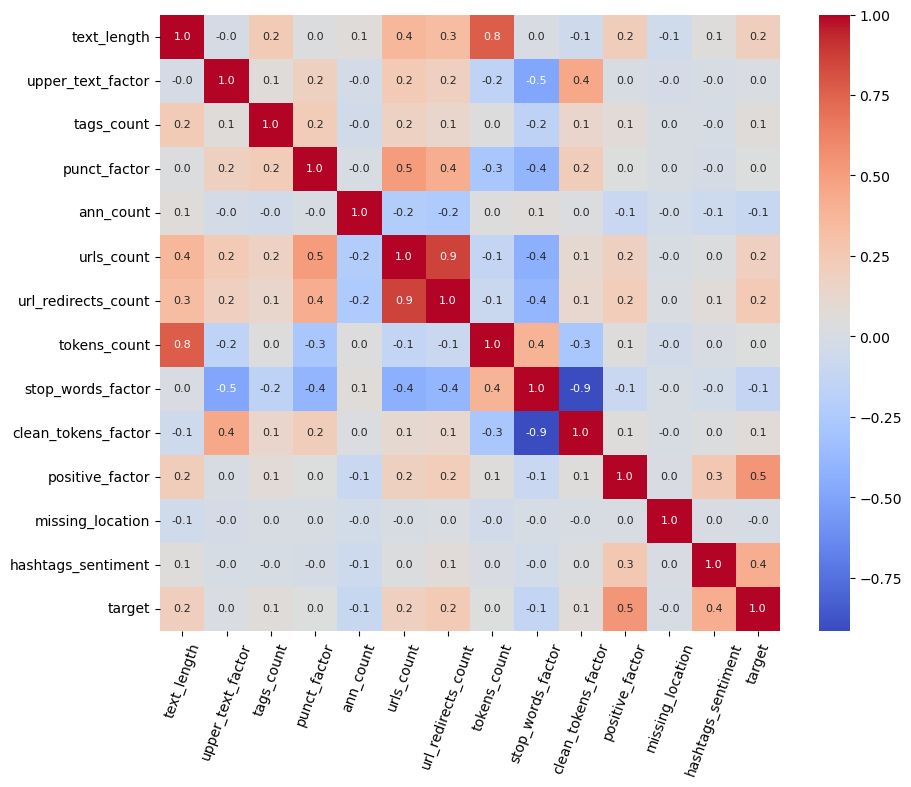

In [20]:
selected_features = ['text_length', 'upper_text_factor', 'tags_count', 'punct_factor', 'ann_count', 
                     'urls_count', 'url_redirects_count',
                     'tokens_count', 'stop_words_factor', 'clean_tokens_factor', 'positive_factor',
                     'missing_location',
                     'hashtags_sentiment',
                     'target']
df_corr = df_train[selected_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, fmt=".1f", cmap='coolwarm', annot_kws={"size": 8}, xticklabels=df_corr.columns, yticklabels=df_corr.columns)
plt.xticks(rotation=70)
plt.show()